In [49]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: roicat


In [3]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

In [4]:
%load_ext autoreload
%autoreload 2
import bnpm

In [5]:
%load_ext autoreload
%autoreload 2
import roicat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


set general parameters

In [6]:
path_tracking_results = r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/stat_and_ops.ROICaT.tracking.results.pkl'

In [7]:
tracking_results = bnpm.file_helpers.pickle_load(path_tracking_results)

In [8]:
dates = [Path(p).parts[-2] for p in tracking_results['input_data']['paths_stat']]
labels = {d: l for d, l in zip(dates, tracking_results['clusters']['labels_bySession'])}

In [9]:
path_classification_results = r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/mouse_0322N.ROICaT.classification_drawn.results.pkl'
classification_results = bnpm.file_helpers.pickle_load(path_classification_results)

In [21]:
iscells_classification = classification_results['preds']

In [23]:
iscells_tqm = {date: np.load(Path(r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/dFoF_and_tqm/') / date / 'jobNum_0' / 'iscell_tqm.npy', mmap_mode='r') for date in labels.keys()}

In [29]:
assert all([ic_tqm.shape[0] == ic_c.shape[0] for ic_tqm, ic_c in zip(iscells_tqm.values(), iscells_classification)])

In [33]:
iscells_final = {date: ic_tqm * ic_c for (date, ic_tqm), ic_c in zip(iscells_tqm.items(), iscells_classification)}

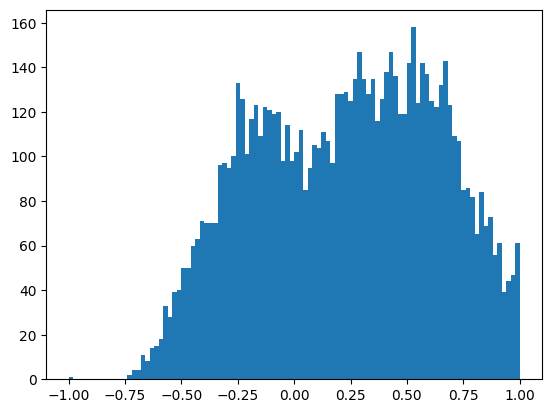

In [11]:
plt.figure()
plt.hist(tracking_results['quality_metrics']['cluster_silhouette'], 100);

In [35]:
labels_unique = np.unique(tracking_results['clusters']['labels'])
iscell_trackingQualityMetrics = tracking_results['quality_metrics']['cluster_silhouette'] > 0.0
assert len(labels_unique == iscell_trackingQualityMetrics)

labels_badQuality = labels_unique[~iscell_trackingQualityMetrics]

In [36]:
labels_processed = [np.array(l, dtype=np.int64) for date, l in labels.items()]

In [37]:
def find_and_replace_values(arr, vals_find, val_replace):
    arr_out = arr.copy()
    arr_out[np.isin(arr_out, vals_find)] = val_replace
    return arr_out

In [38]:
labels_processed = [find_and_replace_values(l, vals_find=labels_badQuality, val_replace=-1) for l in labels_processed]                                            

In [39]:
labels_processed = roicat.util.mask_UCIDs_with_iscell(
    ucids=labels_processed,
    iscell=list(iscells_final.values()),
)

In [40]:
labels_processed = roicat.util.discard_UCIDs_with_fewer_matches(
    ucids=labels_processed,
    n_sesh_thresh=10,
)

INFO: 70.05% of UCIDs in first session appear in at least 10 sessions.


In [41]:
labels_processed = roicat.util.squeeze_UCID_labels(
    ucids=labels_processed,
)

get dFoF

In [42]:
dFoFs = {date: np.load(Path(r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/dFoF_and_tqm/') / date / 'jobNum_0' / 'dFoF.npy', mmap_mode='r') for date in labels.keys()}

In [43]:
dFoF_aligned = roicat.util.match_arrays_with_ucids(
    arrays=list(dFoFs.values()),
    ucids=labels_processed,
    squeeze=True,
)

save aligned dF/F arrays

In [47]:
dir_save = r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/dFoF_aligned/'

In [48]:
for d, dfof in zip(dates, dFoF_aligned):
    path = str(Path(dir_save).resolve() / d / 'dFoF_aligned.npy')
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    np.save(path, dfof.astype(np.float32))